***INSTALL LIBARIES***

In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.3/126.3 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for polyglot: filename=polyglot-16.7.4-py2.py3-none-any.whl size=52562 sha256=f91fc9e500964d3c824c7a59062bbea4e921eb8aafd4091d2686f63a007b1298
  Stored in directory: /root/.cache/pip/wheels/aa/92/4a/b172589446ba537db3bdb9a1f2204f27fe71217981c14ac368
Successfully built polyglot
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.0/260.0 kB 3.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for PyICU: filename=PyICU-2.12-cp310-cp310-linux_x86_64.whl size=1754544 sha256=e43e54b47ae85dc4b31e0307d078dca8724e67657ba61a4f32e99da05b921829
  Stored in directory: /root/.cache/pip/wheels/74/60/95/66d97ac2fdc8be8e526c4254047405fe77feaf064282d1ad07
Successfully built PyICU
Reading package lists... Done
Building dependency tree... Done
Reading st

***IMPORTS***

In [2]:
import numpy as np
import pandas as pd

from polyglot.text import Text

from datasets import load_dataset

from collections import Counter
import matplotlib.pyplot as plt

***PREPARING THE DATASET***

In [6]:
# Load the entire dataset
dataset = load_dataset("polyglot_ner", name = "de")

Generating train split:   0%|          | 0/547578 [00:00<?, ? examples/s]

In [7]:
# Samples from the dataset
print(dataset['train'][0:5])

{'id': ['0', '1', '2', '3', '4'], 'lang': ['de', 'de', 'de', 'de', 'de'], 'words': [['Im', 'Jahr', '2011', 'hatte', 'die', 'Gemeinde', 'etwas', 'mehr', 'als', '3700', 'Mitglieder', '.'], ['Doch', 'die', 'Ruhe', 'trügt', ',', 'Cold', 'und', 'der', 'Gefangene', 'werden', 'erwischt', '.'], ['Ein', 'Jahr', 'spielte', 'er', 'danach', 'für', 'Eintracht', 'Braunschweig', ',', 'wurde', 'dort', 'U', '-', '16', '-', 'Nationalspieler', 'und', 'bekam', 'vom', 'DFB', 'im', 'März', '2007', 'die', 'Auszeichnung', 'als', '„', 'Talent', 'des', 'Monats', '“.'], ['Mai', '1933', 'bei', 'der', 'NS', '-', 'Bücherverbrennung', 'den', 'Flammen', 'übergeben', '.'], ['März', '1958', ')', 'war', 'ein', 'griechisch', '-', 'französischer', 'Leichtathlet', ',', 'der', 'an', 'drei', 'Olympischen', 'Spielen', 'teilnahm', '.']], 'ner': [['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'ORG', 'ORG', 'O', 'O', 'O', 

***EXPLORATORY DATA ANALYSIS (EDA)***

In [8]:
train_data = dataset['train']

# Dataset size
print("Total examples in the dataset:", len(train_data))

# Distribution of entity types
entity_types = Counter([label for example in train_data for label in example['ner']])
print(entity_types)

Total examples in the dataset: 547578
Counter({'O': 9379127, 'LOC': 271964, 'PER': 179291, 'ORG': 169642})


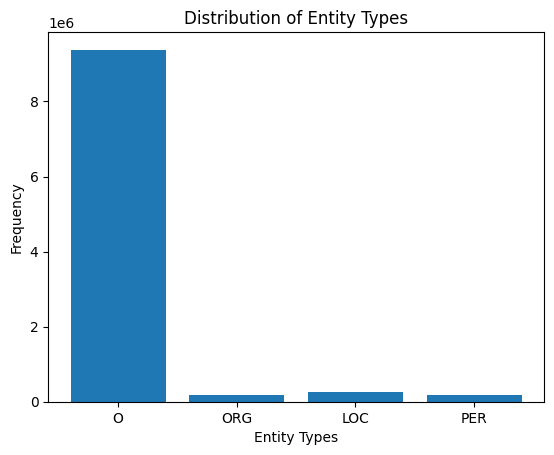

In [9]:
# Plotting
plt.bar(entity_types.keys(), entity_types.values())
plt.title('Distribution of Entity Types')
plt.xlabel('Entity Types')
plt.ylabel('Frequency')
plt.show()

In [10]:
# Sentence Lengths
sentence_lengths = [len(example['words']) for example in train_data]

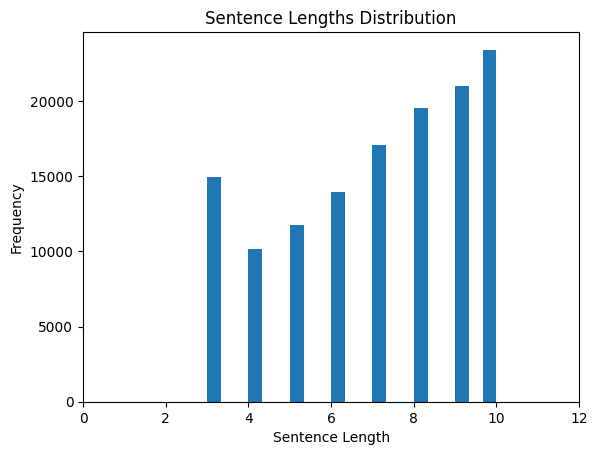

In [11]:
# Sentence_lengths is a list containing the lengths of sentences
plt.hist(sentence_lengths, bins=30, range=(0, 10))
plt.title('Sentence Lengths Distribution')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')

# Set x-axis range
plt.xlim(0, 12)

plt.show()

In [12]:
# The dataset object is an Apache Arrow table which we convert directly to a DataFrame
df = pd.DataFrame(dataset['train'])

# Print head of the df
print(df.head())

  id lang                                              words  \
0  0   de  [Im, Jahr, 2011, hatte, die, Gemeinde, etwas, ...   
1  1   de  [Doch, die, Ruhe, trügt, ,, Cold, und, der, Ge...   
2  2   de  [Ein, Jahr, spielte, er, danach, für, Eintrach...   
3  3   de  [Mai, 1933, bei, der, NS, -, Bücherverbrennung...   
4  4   de  [März, 1958, ), war, ein, griechisch, -, franz...   

                                                 ner  
0               [O, O, O, O, O, O, O, O, O, O, O, O]  
1               [O, O, O, O, O, O, O, O, O, O, O, O]  
2  [O, O, O, O, O, O, ORG, ORG, O, O, O, O, O, O,...  
3                  [O, O, O, O, O, O, O, O, O, O, O]  
4  [O, O, O, O, O, LOC, O, LOC, O, O, O, O, O, O,...  
